### Individual subcomponent test for SW1 ML

In [1]:
import sys
import torch
from torch import nn
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

sys.path.insert(1, 'C:\\Users\\shrey\\Desktop\\NUS- Everything\\Semester 7\\CG4002\\CG4002_B18\\sw1_ml\\src\\data\\')
sys.path.insert(2, 'C:\\Users\\shrey\\Desktop\\NUS- Everything\\Semester 7\\CG4002\\CG4002_B18\\sw1_ml\\src\\model\\')

from load_HAPT_data import load_data
from load_nn_data import load_neural_network_data
from random_forest import rfc, rfc_validation
from support_vector_classifier import svm_classifier
from neural_network_model import neural_network_model_1

In [2]:
dataset = 'C:\\Users\\shrey\\Desktop\\NUS- Everything\\Semester 7\\CG4002\\CG4002_B18\\Datasets\\HAPT_Dataset\\'
labels = dict()

with open(dataset + 'activity_labels.txt') as fh:
    for line in fh:
        label, class_name = line.split()
        labels[class_name] = int(label)

labels_reverse = {v:k for k, v in labels.items()}

In [3]:
X_train, y_train, X_test, y_test = load_data(dataset)

### RANDOM FOREST CLASSIFIER

3 Fold Cross Validation used which gives peak performance accuracy of 91.6%

In [4]:
rf_random_estimate = rfc_validation(X_train, y_train)
rf_random_estimate.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 15.3min finished


{&#39;n_estimators&#39;: 100,
 &#39;min_samples_split&#39;: 2,
 &#39;min_samples_leaf&#39;: 4,
 &#39;max_features&#39;: &#39;sqrt&#39;,
 &#39;bootstrap&#39;: True}

Results of Random Forest Classifier-
Predicted move      LAYING  LIE_TO_SIT  LIE_TO_STAND  SITTING  SIT_TO_LIE  \
Actual move                                                                 
LAYING                 544           0             0        0           0   
LIE_TO_SIT               0          16             7        0           0   
LIE_TO_STAND             1           7            15        0           0   
SITTING                  0           0             0      453           0   
SIT_TO_LIE               0           0             0        0          27   
SIT_TO_STAND             0           0             0        0           0   
STANDING                 0           0             0       33           0   
STAND_TO_LIE             0           1             0        1          12   
STAND_TO_SIT             0           0             0        2           1   
WALKING                  0           0             0        0           0   
WALKING_DOWNSTAIRS       0           0 

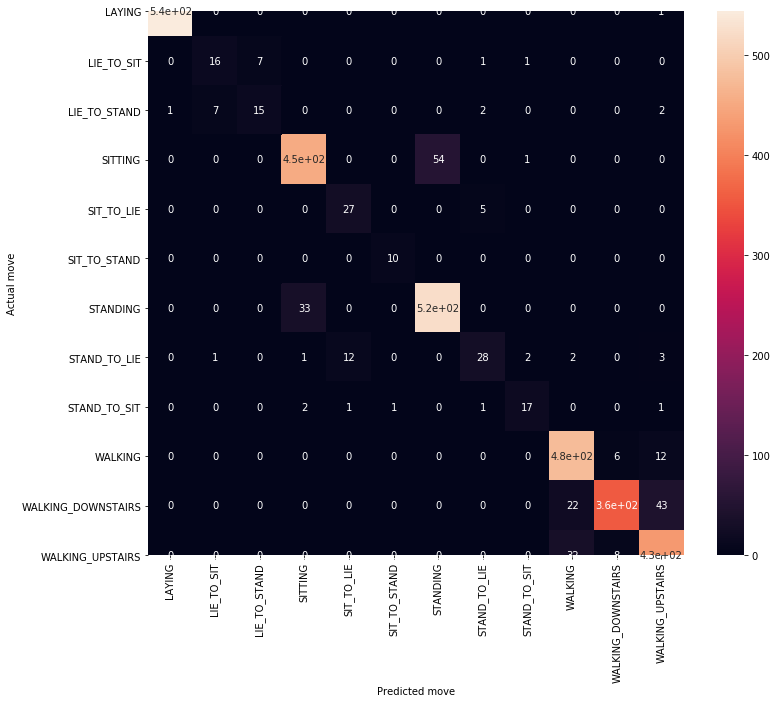

In [5]:
rfc(X_train, y_train, X_test, y_test, labels_reverse, 100, 2, 4, 'sqrt', True)

### SUPPORT VECTOR MACHINE CLASSIFIER

SVM models trained
Results of SVM Classifier-
Accuracy Linear Kernel:  0.9519291587602783
Accuracy Polynomial Kernel:  0.872865275142315
Accuracy Radial Basis Kernel:  0.18184693232131563
Accuracy Sigmoid Kernel:  0.8823529411764706


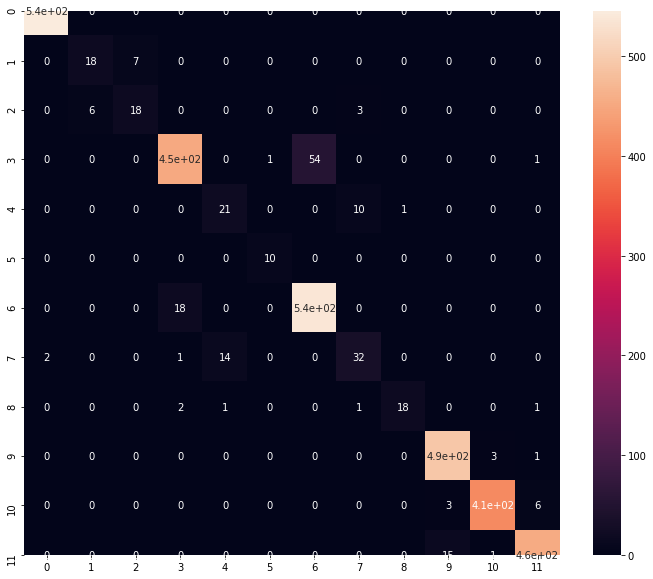

In [6]:
svm_classifier(X_train, y_train, X_test, y_test, labels_reverse, show='l')

### NEURAL NETWORK IMPLEMENTATION

Ignite is a High-level library to help with training neural networks in PyTorch. It comes with an Engine to setup a training loop, various metrics, handlers and a helpful contrib section!

Below we import the following:

* **Engine**: Runs a given process_function over each batch of a dataset, emitting events as it goes.
* **Events**: Allows users to attach functions to an Engine to fire functions at a specific event. Eg: EPOCH_COMPLETED, ITERATION_STARTED, etc.
* **Accuracy**: Metric to calculate accuracy over a dataset, for binary, multiclass, multilabel cases.
* **Loss**: General metric that takes a loss function as a parameter, calculate loss over a dataset.
* **RunningAverage**: General metric to attach to Engine during training.
* **EarlyStopping**: Handler to stop training based on a score function.

In [7]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.handlers import EarlyStopping

nn_model = neural_network_model_1(input_size=X_train.shape[1], hidden_states= [256,128], output_size=X_test.shape[1])
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)

In [14]:
trainloader, testloader = load_neural_network_data(X_train, y_train, X_test, y_test)

In [9]:
def score_function(engine):
    val_loss = engine.state.metrics['crossentropy']
    accuracy = engine.state.metrics['accuracy']
    return accuracy

trainer = create_supervised_trainer(nn_model, optimizer, loss)
evaluator = create_supervised_evaluator(nn_model,
                                        metrics={
                                            'accuracy': Accuracy(),
                                            'crossentropy': Loss(loss)
                                            })

handler = EarlyStopping(patience=5, score_function=score_function, trainer=trainer)
# Note: the handler is attached to an *Evaluator* (runs one epoch on validation dataset).
evaluator.add_event_handler(Events.COMPLETED, handler)

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(trainloader)
    metrics = evaluator.state.metrics
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, metrics['accuracy'], metrics['crossentropy']))

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(testloader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, metrics['accuracy'], metrics['crossentropy']))

trainer.run(trainloader, max_epochs=35)

Training Results - Epoch: 1  Avg accuracy: 0.90 Avg loss: 0.30
Validation Results - Epoch: 1  Avg accuracy: 0.85 Avg loss: 0.40
Training Results - Epoch: 2  Avg accuracy: 0.93 Avg loss: 0.18
Validation Results - Epoch: 2  Avg accuracy: 0.88 Avg loss: 0.28
Training Results - Epoch: 3  Avg accuracy: 0.94 Avg loss: 0.14
Validation Results - Epoch: 3  Avg accuracy: 0.92 Avg loss: 0.20
Training Results - Epoch: 4  Avg accuracy: 0.96 Avg loss: 0.10
Validation Results - Epoch: 4  Avg accuracy: 0.92 Avg loss: 0.20
Training Results - Epoch: 5  Avg accuracy: 0.96 Avg loss: 0.11
Validation Results - Epoch: 5  Avg accuracy: 0.89 Avg loss: 0.30
Training Results - Epoch: 6  Avg accuracy: 0.95 Avg loss: 0.12
Validation Results - Epoch: 6  Avg accuracy: 0.89 Avg loss: 0.28


State:
	iteration: 1458
	epoch: 6
	epoch_length: 243
	max_epochs: 35
	output: 0.26799675822257996
	batch: &lt;class &#39;list&#39;&gt;
	metrics: &lt;class &#39;dict&#39;&gt;
	dataloader: &lt;class &#39;torch.utils.data.dataloader.DataLoader&#39;&gt;
	seed: &lt;class &#39;NoneType&#39;&gt;
	times: &lt;class &#39;dict&#39;&gt;

In [10]:
nb_classes = len(labels_reverse) + 1

confusion_matrix = np.zeros((nb_classes, nb_classes))
correct = total = 0

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = nn_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

confusion_matrix = np.delete(confusion_matrix, 0, 0)
confusion_matrix = np.delete(confusion_matrix, 0, 1)


In [10]:
print('Accuracy of the network on the test inputs: %d %%' % (
    100 * correct / total))
print('Confusion Matrix of Neural Network- ')
print(confusion_matrix)

Accuracy of the network on the test inputs: 91 %
Confusion Matrix of Neural Network- 
[[493.   1.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ 18. 447.   1.   0.   0.   0.   3.   0.   0.   0.   2.   0.]
 [ 13.  64. 343.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   1.   0. 480.  25.   0.   1.   1.   0.   0.   0.   0.]
 [  0.   0.   0.  59. 497.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   6. 539.   0.   0.   0.   0.   0.   0.]
 [  0.   1.   0.   2.   1.   0.  16.   0.   0.   0.   3.   0.]
 [  0.   0.   0.   0.   0.   0.   1.   9.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  13.   0.  19.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   0.  20.   0.   4.]
 [  0.   0.   0.   3.   0.   1.   0.   0.   6.   1.  38.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.  20.   3.   3.]]


&lt;matplotlib.axes._subplots.AxesSubplot at 0x2aaa7eb55f8&gt;

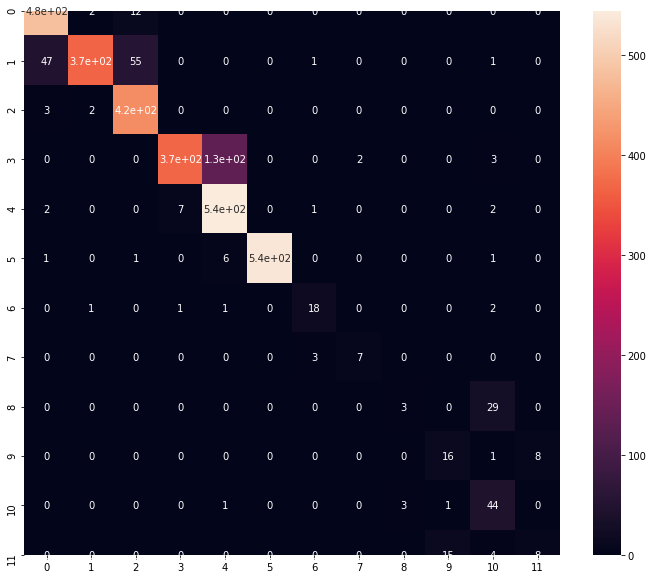

In [11]:
plt.figure(figsize = (12, 10))
sn.heatmap(confusion_matrix, annot=True)

## MODEL COMPARISONS

| Model          | Sub-category          | Accuracy |
|:--------------:|:---------------------:|---------:|
| Random Forests |  3 Fold Cross Validation | 91.6%   |
|       SVM      | <ul><li>Linear</li><li>Polynomial</li><li>RBF</li><li>Sigmoid</li></ul> | <ul><li>95.2%</li><li>87.3%</li><li>18.2%</li><li>88.2%</li></ul> |
| Neural Network | PyTorch Ignite Engine | 91% |

On comparing the classification accuracy between the different models and considering the fact that inference will have to be carried out on the Ultra96 FPGA, we see that the simple Neural Network model (created using PyTorch libraries) is the winner here given the ease of running inference on the FPGA. 

Within the neural network implementation, having three hidden layers instead of two provided negligible improvement in the accuracy score- So we have decided to go ahead with a neural network implementation with two hidden layers so that creating the inference model on the FPGA is easier. 

## CLASSIFICATION OF REAL-TIME/STREAMING DATA

We will be training a quantized Neural Network model on data received from all six project members. Once, the model has been trained and the classification accuracy is deemed suitable, we will export it to the ONNX representation that FINN will use to run inference on the FPGA board. The real-time classification of the dance move will be done through a greedy majority algorithm. Since the feature space uses a slicing window technique, we will run the inference on continous window slices and output a classification once a certain dance move is classified by the Inference model for a defined number of windows.

The problem of classifying dance moves and relative location has been split up into two- the neural network model will classify dance moves continuously from the sensor on the wrist while another simple ML model will be used to detect dancer position based on data obtained from the dedicated sensor on the legs. 